<a href="https://colab.research.google.com/github/Pollycarpus/traffic-sign-detection/blob/master/Run_models_on_new_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running on new images
This notebook will walk you step by step through the process of using a pre-trained model to detect traffic signs in an image.

# Imports

In [0]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
import tensorflow as tf
from matplotlib import pyplot as plt
from PIL import Image
import glob as glob

# Environment setup

In [0]:
%matplotlib inline
import sys
# Append your Tensorflow object detection and darkflow directories to your path
sys.path.append('PATH_TO_TENSORFLOW_OBJECT_DETECTION_FOLDER') # ~/tensorflow/models/research/object_detection
sys.path.append('PATH_TO_DARKFLOW_FOLDER') # ~/darkflow
from utils import label_map_util
from utils import visualization_utils as vis_util

# Tensorflow Object Detection API

## Model preparation 

In [0]:
MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous'
# MODEL_NAME = 'faster_rcnn_resnet_101'
# MODEL_NAME = 'faster_rcnn_resnet50'
# MODEL_NAME = 'faster_rcnn_inception_v2'
# MODEL_NAME = 'rfcn_resnet101'
# MODEL_NAME = 'ssd_inception_v2'
# MODEL_NAME = 'ssd_mobilenet_v1'

In [0]:
# Path to frozen detection graph. This is the actual model that is used for the traffic sign detection.
MODEL_PATH = os.path.join('models', MODEL_NAME)
PATH_TO_CKPT = os.path.join(MODEL_PATH,'inference_graph/frozen_inference_graph.pb')

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('gtsdb_data', 'gtsdb3_label_map.pbtxt')

NUM_CLASSES = 3

## Load a (frozen) Tensorflow model into memory

In [0]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `2`, we know that this corresponds to `mandatory`.

In [0]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(label_map)

item {
  name: "prohibitory"
  id: 1
}
item {
  name: "mandatory"
  id: 2
}
item {
  name: "danger"
  id: 3
}



## Helper code

In [0]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

## Detection

In [0]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))

# Size, in inches, of the output images.
IMAGE_SIZE = (20, 20)

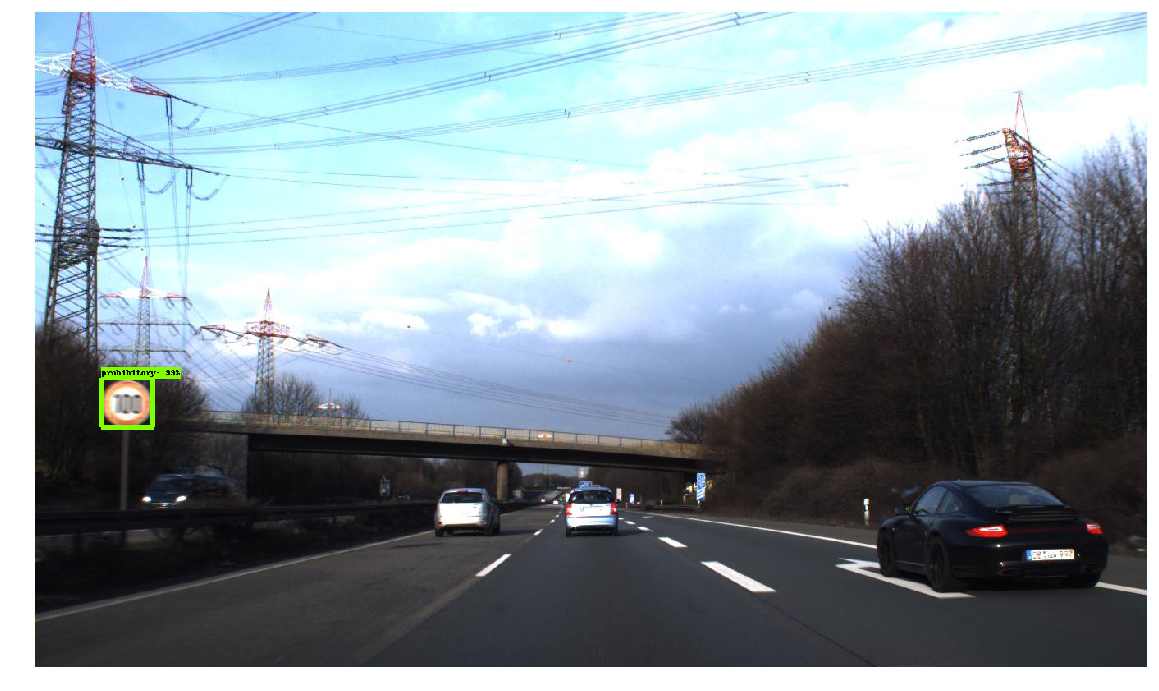

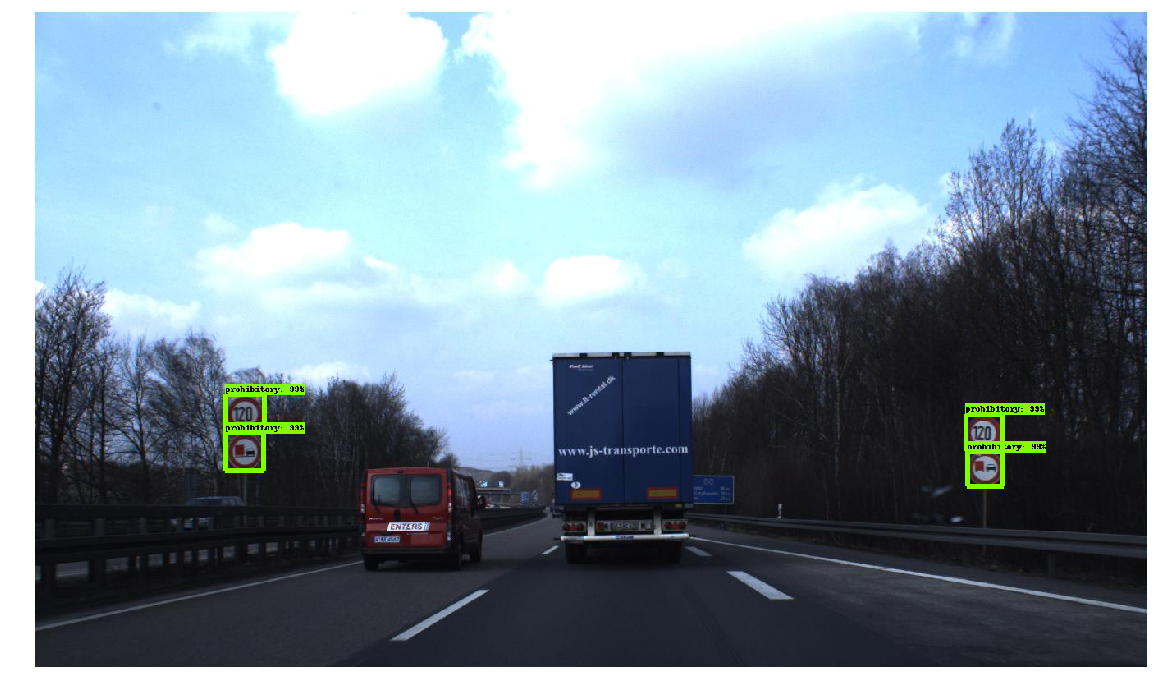

In [0]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        for idx, image_path in enumerate(TEST_IMAGE_PATHS):
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            # Each box represents a part of the image where a particular object was detected.
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            # Actual detection.
            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=6)
            plt.figure(idx, figsize=IMAGE_SIZE)
            plt.axis('off')
            plt.imshow(image_np)

# Darkflow

## Model preparation 

In [0]:
from darkflow.net.build import TFNet
import cv2

MODEL_NAME = 'yolo_v2'
MODEL_PATH = os.path.join('models', MODEL_NAME)

options = {'model': os.path.join(MODEL_PATH, '{}.cfg'.format(MODEL_NAME)),
           'labels': os.path.join(MODEL_PATH, 'labels.txt'),
           'backup': MODEL_PATH,
           'load' : 50500,
           'threshold': 0.5,
           'gpu' : 1.0}

tfnet = TFNet(options)

Parsing models/yolo_v2/yolo_v2.cfg
Loading None ...
Finished in 0.00011587142944335938s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 608, 608, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 608, 608, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 304, 304, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 304, 304, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 152, 152, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Init  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 152, 152, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 76, 76, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 76, 76, 256)
 Init  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      |

## Helper code

In [0]:
def plot_rectangle(bbox, ax, class_name, edgecolor, confidence=None):
    xmin = bbox[0]
    ymin = bbox[1]
    xmax = bbox[2]
    ymax = bbox[3]
    left = xmin
    right = xmax
    top = ymin
    bot = ymax
    ax.add_patch(
        plt.Rectangle((left, top),
                      right-left,
                      bot-top, fill=False,
                      edgecolor=edgecolor, linewidth=3.5)
        )
    label = '{:s}'.format(class_name)
    label_pos_y = top-10
    if confidence:
        label += ' {0:.2f}'.format(confidence)
        label_pos_y = bot+20
    ax.text(left, label_pos_y,label,
            bbox=dict(facecolor=edgecolor, alpha=0.5),
            fontsize=14, color='white')

In [0]:
def get_label_id(label_name):
    for category in categories:
        if category['name'] == label_name:
            return category['id']

## Detection

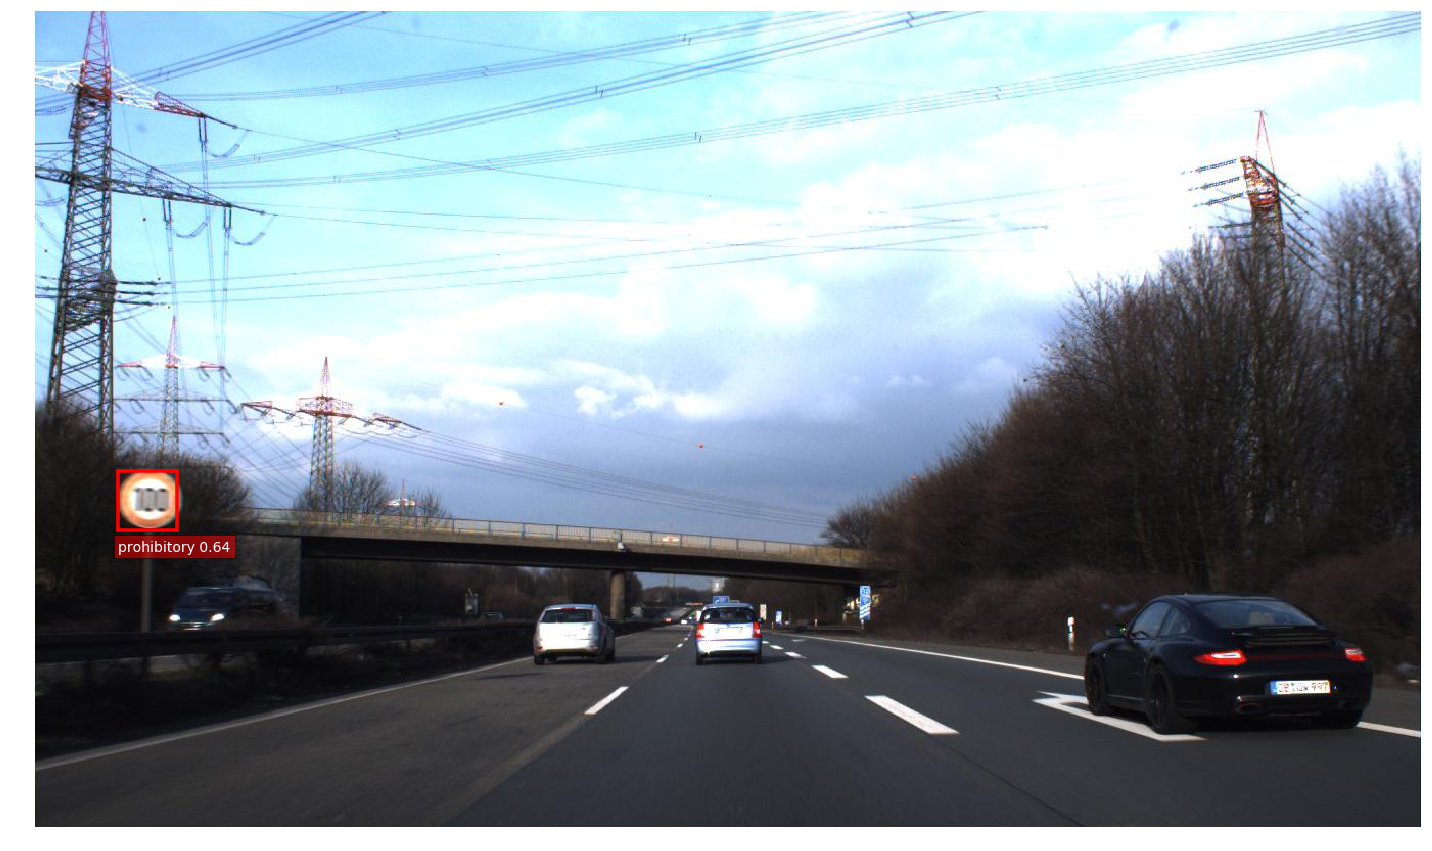

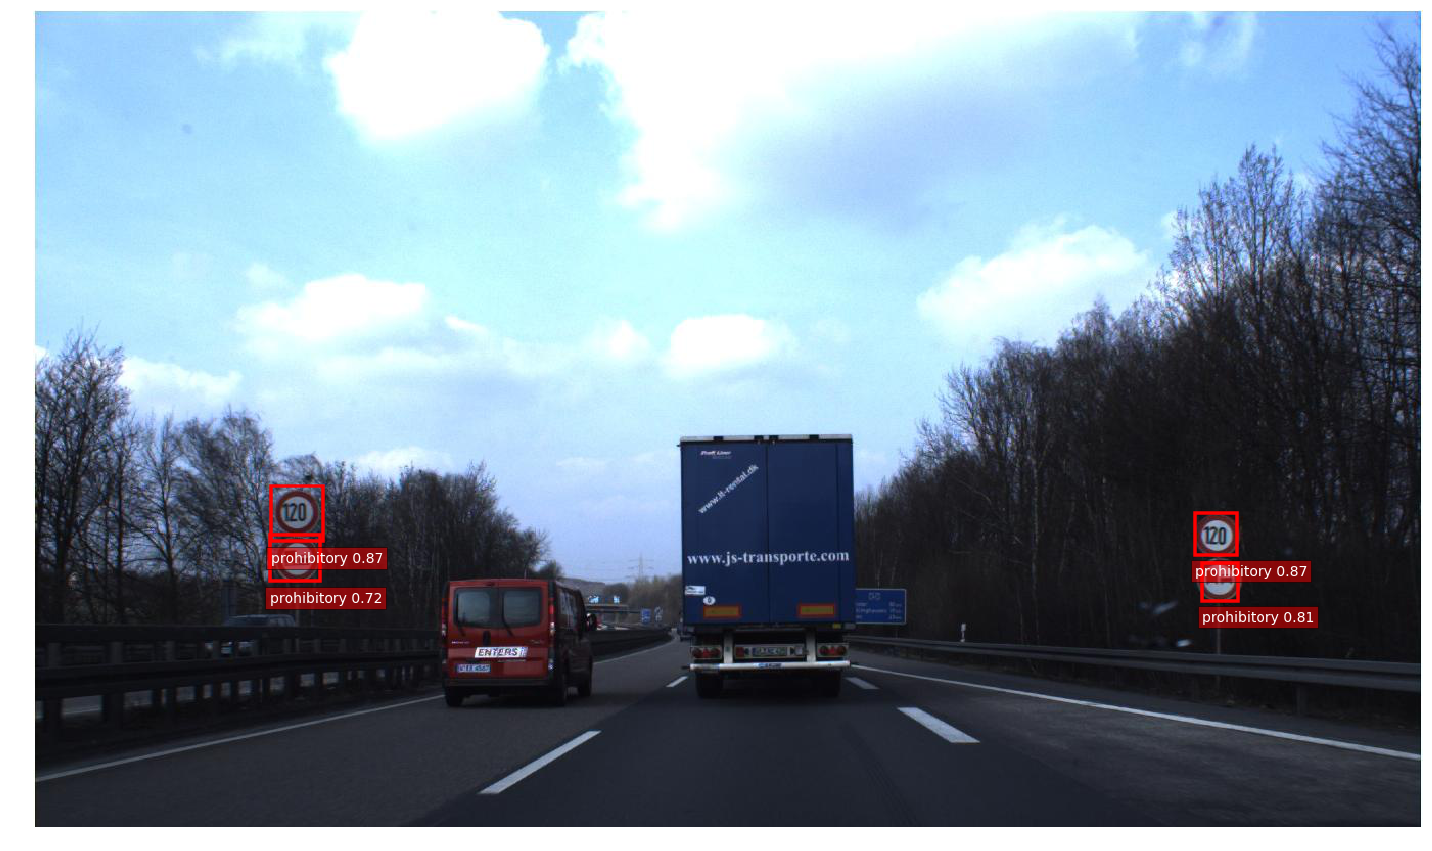

In [0]:
min_score_thresh = 0.5
for image_path in TEST_IMAGE_PATHS:
    fig, ax = plt.subplots(figsize=(20, 20))
    image = Image.open(image_path)
    image_name = os.path.basename(image_path)
    width, height = image.size
    ax.imshow(image)
    
    image_np = load_image_into_numpy_array(image)
    image_np = image_np[:,:,::-1] # rgb -> bgr
    pred_results = tfnet.return_predict(image_np)

    for idx, det in enumerate(pred_results):
        score = det['confidence']
        if score > min_score_thresh:
            bbox = det['topleft']['x'], det['topleft']['y'], det['bottomright']['x'], det['bottomright']['y']
            label = get_label_id(det['label'])
            plot_rectangle(bbox,ax,category_index[label]['name'],'red', score)
    plt.draw()
    fig.tight_layout()
    plt.axis('off')
    plt.show()